In [1]:
import numpy as np
import random
from rdkit import Chem
import matplotlib.pyplot as plt
from utils import load_dataset_df, fp_generator

No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
No normalization for NumAmideBonds. Feature removed!
No normalization for NumAtomStereoCenters. Feature removed!
No normalization for NumBridgeheadAtoms. Feature removed!
No normalization for NumHeterocycles. Feature removed!
No normalization for NumSpiroAtoms. Feature removed!
No normalization for NumUnspecifiedAtomStereoCenters. Feature removed!
No normalization for Phi. Feature removed!
Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped loading modules with transformers dependency. No module named 'transformers'
cannot import name 'HuggingFaceModel' from 'deepchem.models.torch_models' (c:\Users\knsve\Desktop\MEI\Tese\torch\snn_venv\lib\site-packages\deepchem\models\torch_models\__init__.py)
Skipped loading modules with pytorch-geometri

#### Load DataFrame

In [2]:
files = ['tox21.csv','sider.csv', 'BBBP.csv']
dt_file = files[2]

df, targets = load_dataset_df(filename=dt_file)
print(targets)

target_name = targets[0]
df = df[[target_name, 'smiles']].dropna()


['p_np']


#### Molecule to Fingerprint Vizualization

C1=C(C=CC=C1N3CCN(CCC2=N[NH]C(=C2)C)CC3)C
52
15 ((3, 2),)
25 ((4, 2),)
31 ((2, 2),)
33 ((17, 0), (20, 0), (6, 3))
64 ((3, 1),)


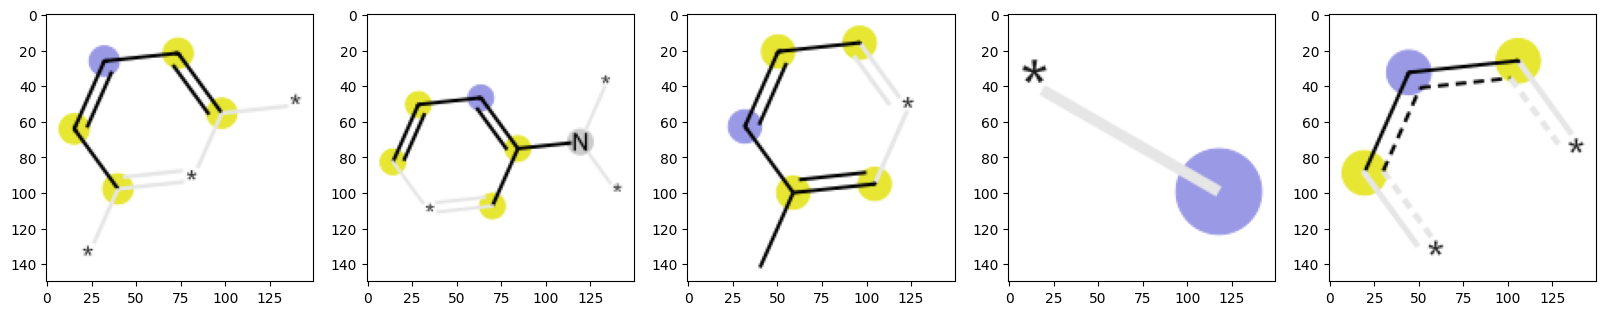

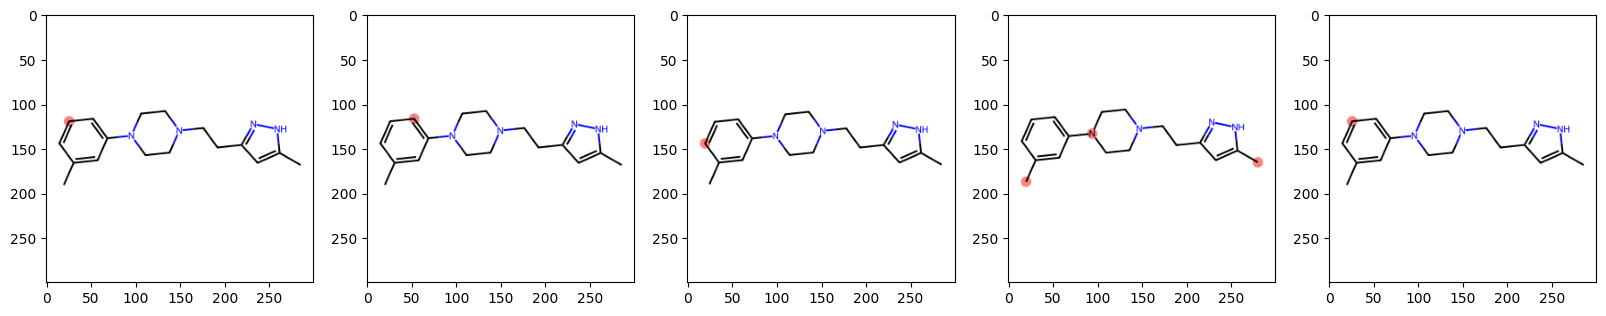

In [6]:
from rdkit.Chem import Draw, AllChem
from IPython.display import display


row = df.iloc[random.randint(0, len(df))]
print(row['smiles'])
mol = Chem.MolFromSmiles(row['smiles'])

if mol is not None:
    img = Draw.MolToImage(mol)

#TODO: (at a later point)
""" mol2 = Chem.RWMol(mol)
mol2 = mol2.RemoveAtom(1)

mol2 = Chem.MolToSmiles(mol2)
mol2 = Chem.SanitizeMol(mol2)


mol2 = Chem.Mol(mol2)
img2 = Draw.MolToImage(mol2)
display(img2) """

fpgen = fp_generator('morgan', radius=3)
ao = AllChem.AdditionalOutput()
ao.CollectBitInfoMap()

fp = fpgen(mol,additionalOutput=ao) ## tentar converter para (#, #) e depois para bits
bi = ao.GetBitInfoMap()

fp = np.array(fp)
print(fp.sum())
fig, axs = plt.subplots(1, 5, figsize=(20, 20))
fig2, axs2 = plt.subplots(1, 5, figsize=(20, 20))

for i, id in enumerate(list(bi.keys())[:5]):
    print(id, bi[id])
    mfp2_svg = Draw.DrawMorganBit(mol, bitId=id, bitInfo=bi)

    atoms = [info[0] for info in bi[id]]
    colors = {idx: (1, 1, 0) for idx in atoms}

    img2 = Draw.MolToImage(mol, highlightAtoms=atoms, highlightAtomColors=colors)
    
    axs[i].imshow(mfp2_svg)
    axs2[i].imshow(img2)


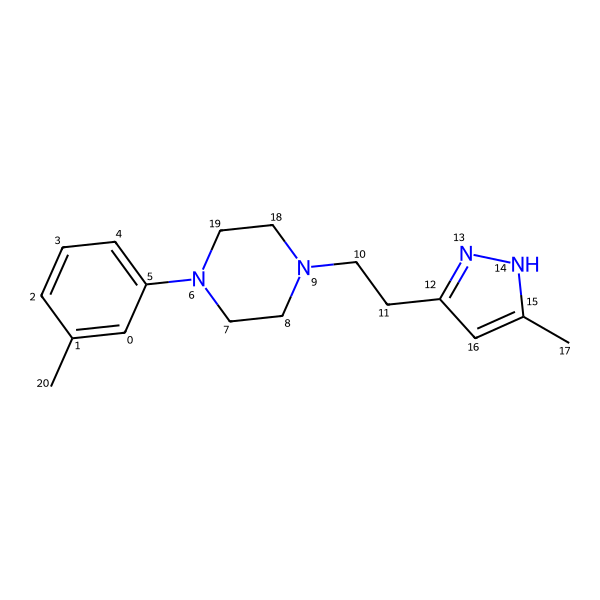

In [52]:
for i, atom in enumerate(mol.GetAtoms()):
    # For each atom, set the property "molAtomMapNumber" to a custom number, let's say, the index of the atom in the molecule
    atom.SetProp("atomNote", f"{i}")
    
Draw.MolToImage(mol, size=(600, 600))

In [ ]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.rdchem import Mol

def get_substructures(mol: Mol, num_subs=5, sub_size=12):
    fragments = []
    for _ in range(num_subs):
        atom_indices = random.sample(range(mol.GetNumAtoms()), min(sub_size, mol.GetNumAtoms()))
        submol = Chem.PathToSubmol(mol, atom_indices)
        fragments.append(submol)
    return fragments

print(row['smiles'])
mol = Chem.MolFromSmiles(row['smiles'])

if mol:
    substructures = get_substructures(mol)
    img = Draw.MolsToGridImage(substructures, molsPerRow=5, useSVG=False)
    display(img)

C1=N[N](C2=C1C(=C(C(=N2)C)C(OCC)=O)NCCCC)CC


ArgumentError: Python argument types in
    MolDraw2D.DrawMolecules(MolDraw2DCairo, list)
did not match C++ signature:
    DrawMolecules(class RDKit::MolDraw2D {lvalue} self, class boost::python::api::object mols, class boost::python::api::object highlightAtoms=None, class boost::python::api::object highlightBonds=None, class boost::python::api::object highlightAtomColors=None, class boost::python::api::object highlightBondColors=None, class boost::python::api::object highlightAtomRadii=None, class boost::python::api::object confIds=None, class boost::python::api::object legends=None)